In [1]:
import sys
sys.path.append("../..")

# Noisy Pendulum - Extended Kalman Filter and Smoother Examples

Estimate pendulum state with EKF and ERTS as in Examples 7.6 and 13.2 of the book

_Simo Särkkä and Lennart Svensson (2023), Bayesian Filtering and Smoothing, 2nd ed., Cambridge University Press._

See LICENSE provided with the software.

## Imports

### Standard imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg, stats
import tqdm

### Helpers imports

In [3]:
from python.common_utilities import generate_pendulum, RandomState, rmse, plot_pendulum

## Routine

Set the parameters:

In [4]:
dt = 0.01
g  = 9.81

In [5]:
Q  = 0.01 * np.array([[dt ** 3 / 3, dt ** 2 / 2], 
                      [dt ** 2 / 2, dt]])
R  = 0.1 * np.eye(1)

In [6]:
x_0 = np.array([1.5, 0.])

## Simulate data

In [7]:
random_state = RandomState(1)
steps = 500

timeline, states, observations = generate_pendulum(x_0, g, Q, dt, R, steps, random_state)

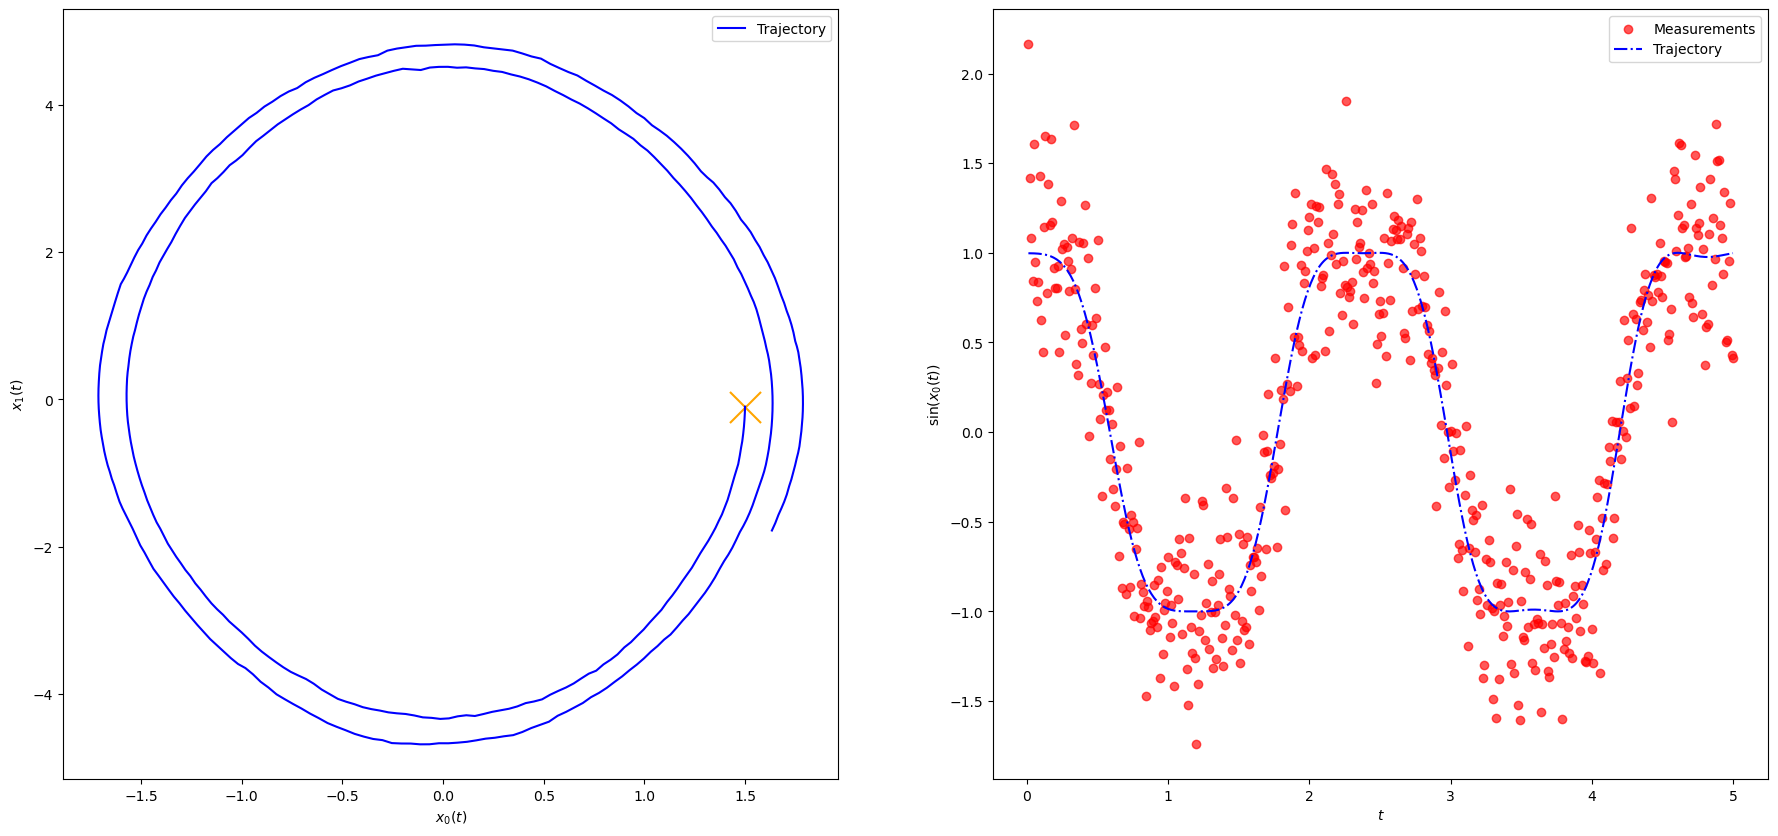

In [8]:
plot_pendulum(timeline, observations, states, "Trajectory")

## Extended Kalman Filter

In [9]:
m_0 = np.array([1.6, 0.])  # Slightly off
P_0 = np.array([[0.1, 0.], 
                [0., 0.1]])

In [10]:
def extended_kalman_filter(m_0, P_0, g, Q, dt, R, observations):
    n = m_0.shape[-1]
    steps = observations.shape[0]
    
    ekf_m = np.empty((steps, n))
    ekf_P = np.empty((steps, n, n))
    
    m = m_0[:]
    P = P_0[:]
    
    for i in range(steps):
        y = observations[i]
        
        # Jacobian of the dynamic model function
        F = np.array([[1., dt], 
                      [-g * dt * np.cos(m[0]), 1.]])
        
        # Predicted state distribution
        m = np.array([m[0] + dt * m[1],
                      m[1] - g * dt * np.sin(m[0])])
        P = F @ P @ F.T + Q
        
        # Predicted observation
        h = np.sin(m[0])
        H = np.array([[np.cos(m[0]), 0.]])
        S = H.dot(P.dot(H.T)) + R
        
        # Gain
        # More efficient and stable way of computing K = P @ H.T @ linalg.inv(S)
        # This also leverages the fact that S is known to be a positive definite matrix (assume_a="pos")
        K = linalg.solve(S, H @ P, assume_a="pos").T 
        m = m + K @ np.atleast_1d(y - h)
        P = P - K @ S @ K.T
        
        ekf_m[i] = m
        ekf_P[i] = P
    return ekf_m, ekf_P

In [11]:
ekf_m, ekf_P = extended_kalman_filter(m_0, P_0, g, Q, dt, R, observations)

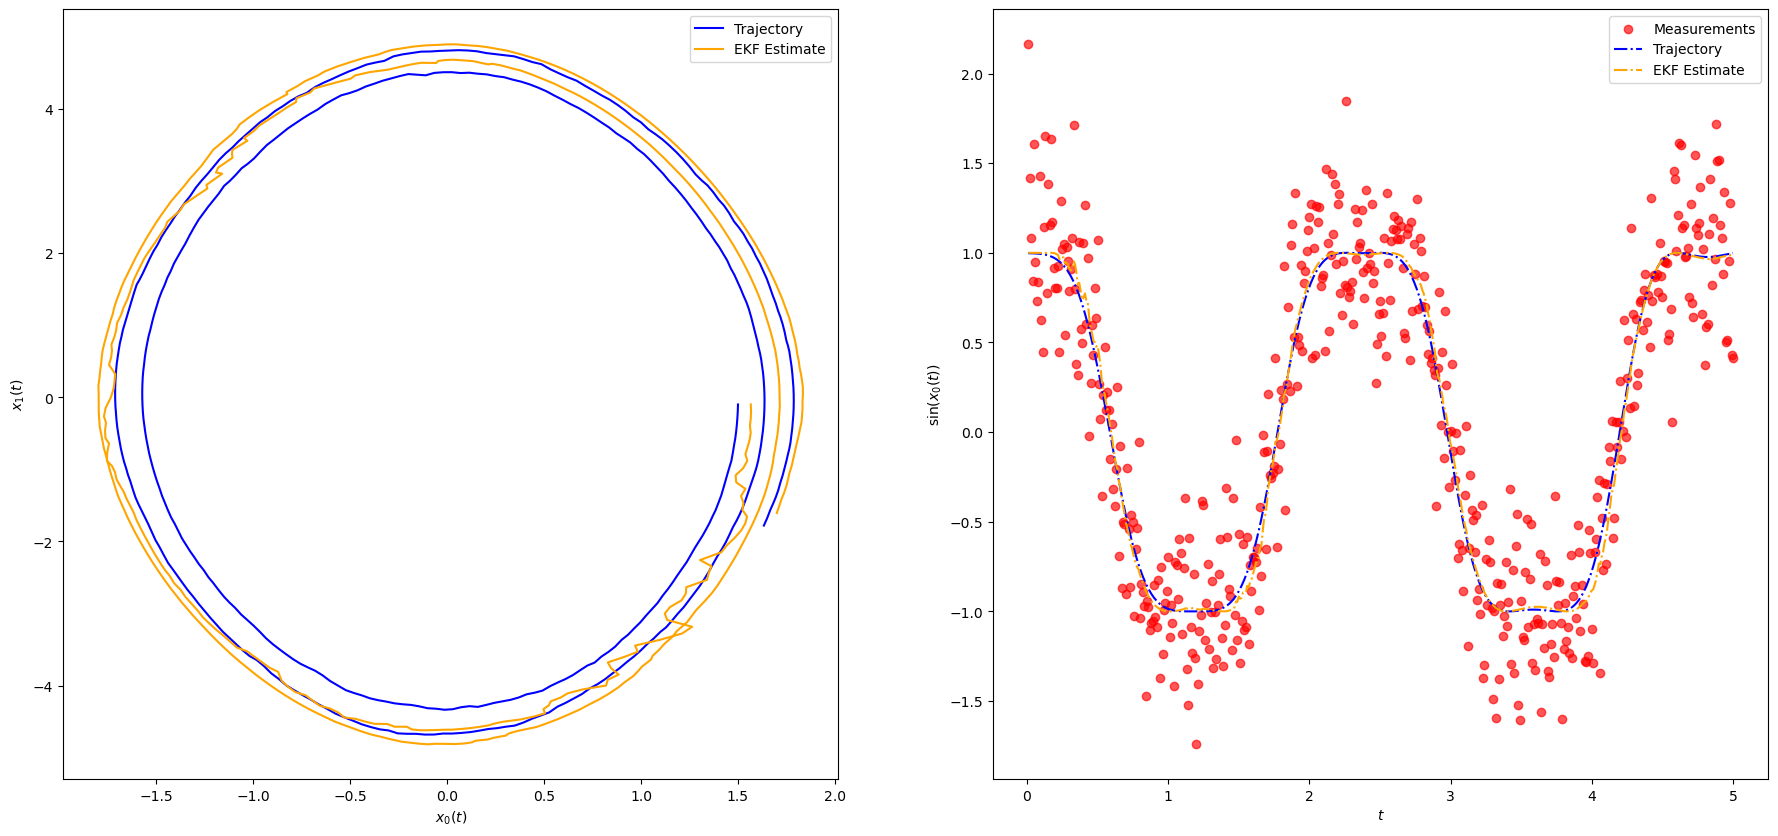

In [12]:
plot_pendulum(timeline, observations, states, "Trajectory", ekf_m, "EKF Estimate")

In [13]:
rmse_ekf = rmse(ekf_m[:, :1], states[:, :1])
print(f"EKF RMSE: {rmse_ekf}")

EKF RMSE: 0.10306106181239291


## Extended RTS

In [14]:
def extended_smoother(ekf_m, ekf_P, g, Q, dt):    
    steps, M = ekf_m.shape
    
    rts_m = np.empty((steps, M))
    rts_P = np.empty((steps, M, M))
    
    m = ekf_m[-1]
    P = ekf_P[-1]
    
    rts_m[-1] = m
    rts_P[-1] = P
    
    for i in range(steps-2, -1, -1):
        filtered_m = ekf_m[i]
        filtered_P = ekf_P[i]
        
        F = np.array([[1., dt], 
                      [-g * dt * np.cos(filtered_m[0]), 1.]])
        
        mp = np.array([filtered_m[0] + dt * filtered_m[1], 
                       filtered_m[1] - g * dt * np.sin(filtered_m[0])])
        Pp = F @ filtered_P @ F.T + Q
        
        # More efficient and stable way of computing Gk = filtered_P @ A.T @ linalg.inv(Pp)
        # This also leverages the fact that Pp is known to be a positive definite matrix (assume_a="pos")
        Gk = linalg.solve(Pp, F @ filtered_P, assume_a="pos").T 

        m = filtered_m + Gk @ (m - mp)
        P = filtered_P + Gk @ (P - Pp) @ Gk.T
        
        rts_m[i] = m
        rts_P[i] = P

    return rts_m, rts_P


In [15]:
rts_m, rts_P = extended_smoother(ekf_m, ekf_P, g, Q, dt)

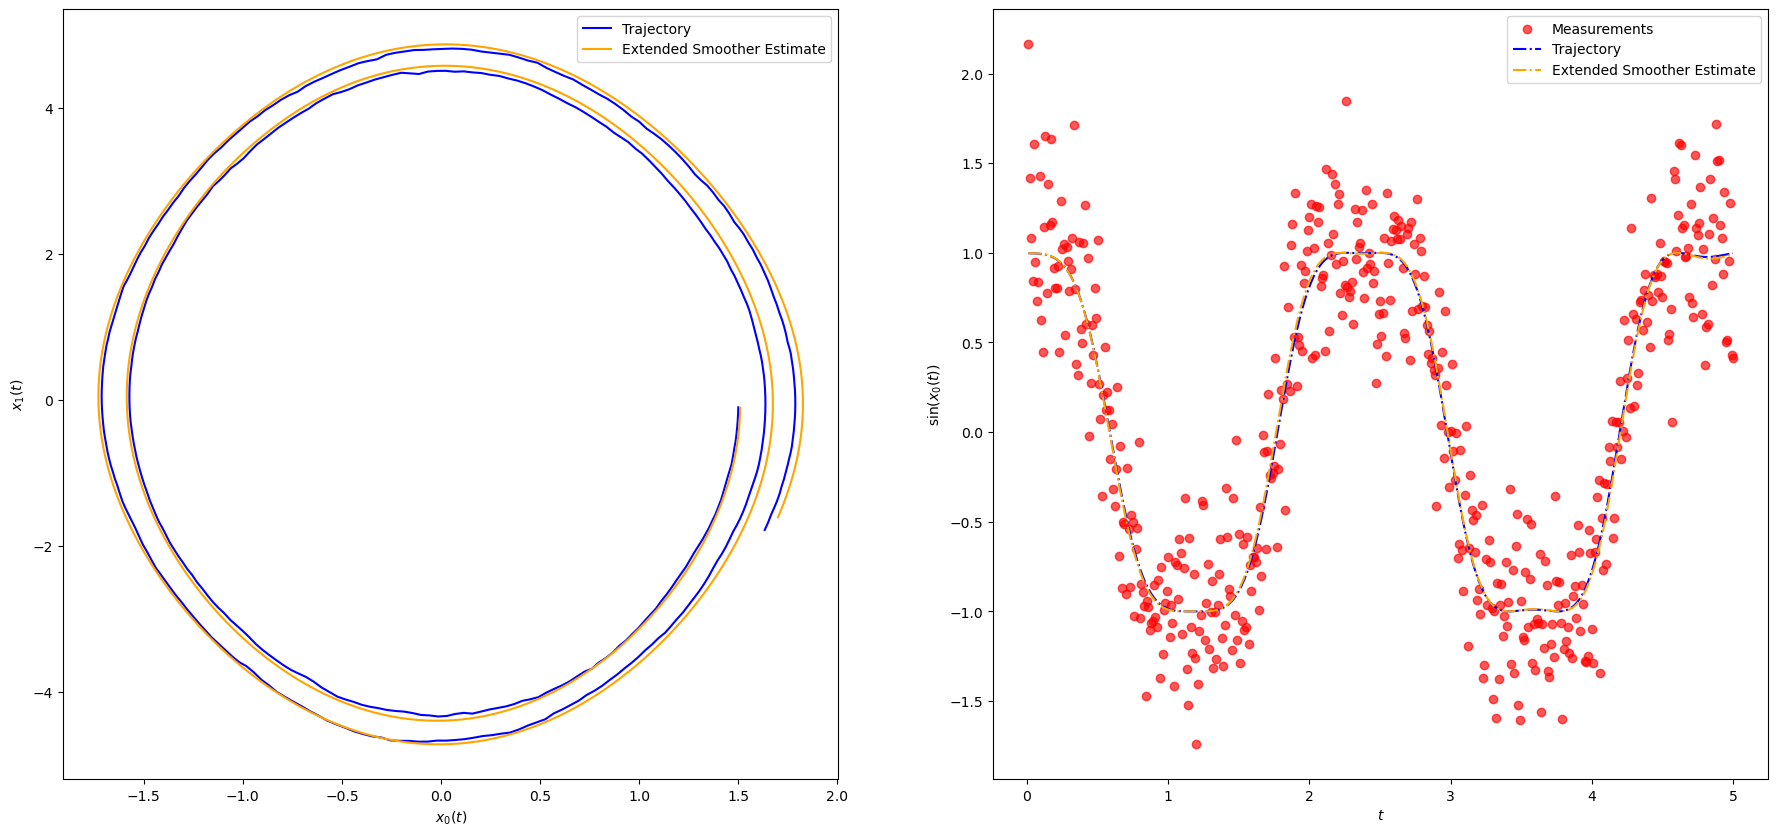

In [16]:
plot_pendulum(timeline, observations, states, "Trajectory", rts_m, "Extended Smoother Estimate")

In [17]:
rmse_erts = rmse(rts_m[:, :1], states[:, :1])
print(f"ERTS RMSE: {rmse_erts}")

ERTS RMSE: 0.027612762479910007
